# EDA of the demographic and clinical data in the OASIS-1 dataset 

## Goal of the EDA 
The overall goal of this EDA is to get some first insights in to the numeric and image data in the OASIS-1 dataset (https://www.oasis-brains.org). This dataset consists of 416 subjects with 434 MR sessions in total. In the first part of the EDA the demographic, clinical information and anatomic volumes will be visualized with the clinical dementia rating (CDR) to find out if there is a correlation between any of those parameters and risk of getting Alzheimer (CDR > 0). In the second part, the image dataset will be analyzed. 

## The dataset 
The dataset consists of MRI images and numerical data for 416 subjects, of which 316 were diagnosed as being non-demented (CDR = 0, control group) and 100 with being demented ranging from very mild dementia (0.5), mild dementia (1) to moderate dementia (2). The gender is male and female, the age range from 18 to 96. All subjects are right handed. 

### Column description 

- ID - Patient ID 
- M/F - gender, male or female 
- Hand - right handed 
- Educ - education code, 1: less than highschool, 2: high school grad, 3: some college, 4: college grad, 5: beyond college 
- SES - socioeconomic status, categories from 1 (highest status) to 5 (lowest status)
- MMSE - ranges from 0 to 30 (best)
- CDR - clinical dementia rating, 0 = no dementia, 0.5 = very mild, 1 = mild, 2 = moderate dementia 
- eTIV - estimated total intracranial volume ($mm^3$)
- nWBV - percent of all voxels in the atlas-masked image that are labeled as white or gray matter
- ASF - atlas scaling factor, computed scaling factor, that transform native-space brain ad skull to atlas target 
- Delay - images from subsequent scan session (less than 90 days later)


## Load required packages and dataset 

In [2]:
#Import packages for data analysis and visualization 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as snsfrom 
from matplotlib.patches import Rectangle
import os
from EDA_functions import *
import sys
sys.path.append('../')

from preprocessing.image_processing import load_MRI_gifs, extract_box, stacked_boxes
from preprocessing.getdata import get_csvdata, get_slices

#set a colorcode for all the plots 
sns.set_palette(palette='ch:start=.2,rot=-.3')

In [3]:
#Import the dataset

df=get_csvdata(drop_contradictions=False, drop_young=False, multiclass=True)

### Part 1 - General investigation of the dataset

In [4]:
# Let us have a look on the dataset 
df.head(2)

,ID,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,label,AD,CN,MCI,dataset
0,OAS1_0001_MR1,F,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,CN,0,1,0,OASIS
1,OAS1_0002_MR1,F,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,CN,0,1,0,OASIS


In [5]:
#Check out what kind of data we have and how many non-null values 
print(df.shape)
df.info()

(436, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ID       436 non-null    object 
 1   M/F      436 non-null    object 
 2   Age      436 non-null    int64  
 3   Educ     235 non-null    float64
 4   SES      216 non-null    float64
 5   MMSE     235 non-null    float64
 6   CDR      436 non-null    float64
 7   eTIV     436 non-null    int64  
 8   nWBV     436 non-null    float64
 9   ASF      436 non-null    float64
 10  label    436 non-null    object 
 11  AD       436 non-null    uint8  
 12  CN       436 non-null    uint8  
 13  MCI      436 non-null    uint8  
 14  dataset  436 non-null    object 
dtypes: float64(6), int64(2), object(4), uint8(3)
memory usage: 42.3+ KB


We can see that in our Education column (Educ), Socioeconomic status (SES), MMSE and CDR there is almost half of the data missing. Also in the delay column there are only 20 non-null values. Because of this we will completely drop the delay column. We will also drop the hand column since all or subjects are right-handed and thus this column does not have any further information.
For CDR the NaN values correspond to patients with non dementia and can just be replaced with 0. For the MMSE we can fill in the mean values for the non dementia people. 
In the publication from Marcus et al. (https://pubmed.ncbi.nlm.nih.gov/17714011/, DOI: 10.1162/jocn.2007.19.9.1498), it is described, that only the individuals older than 60 assessed the full Alzheimer Disease Research Center (ADRC) full clinical test which might be the reason why we have missing values for the younger patients. For this reason, we will drop the rows with the missing values and only use the remaining table for our EDA. 

In [6]:
#Get the statistical values for the dataset 
df.describe()

,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,AD,CN,MCI
count,436.000000,235.000000,216.000000,235.00000,436.00000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000
mean,51.357798,3.178723,2.490741,27.06383,0.15367,1481.919725,0.791670,1.198894,0.068807,0.770642,0.160550
std,25.269862,1.311510,1.120593,3.69687,0.31515,158.740866,0.059937,0.128682,0.253417,0.420903,0.367538
min,18.000000,1.000000,1.000000,14.00000,0.00000,1123.000000,0.644000,0.881000,0.000000,0.000000,0.000000
25%,23.000000,2.000000,2.000000,26.00000,0.00000,1367.750000,0.742750,1.111750,0.000000,1.000000,0.000000
50%,54.000000,3.000000,2.000000,29.00000,0.00000,1475.500000,0.809000,1.190000,0.000000,1.000000,0.000000
75%,74.000000,4.000000,3.000000,30.00000,0.00000,1579.250000,0.842000,1.284250,0.000000,1.000000,0.000000
max,96.000000,5.000000,5.000000,30.00000,2.00000,1992.000000,0.893000,1.563000,1.000000,1.000000,1.000000


Before we start preprocessing the data we will have some basic investigation of the original dataset.

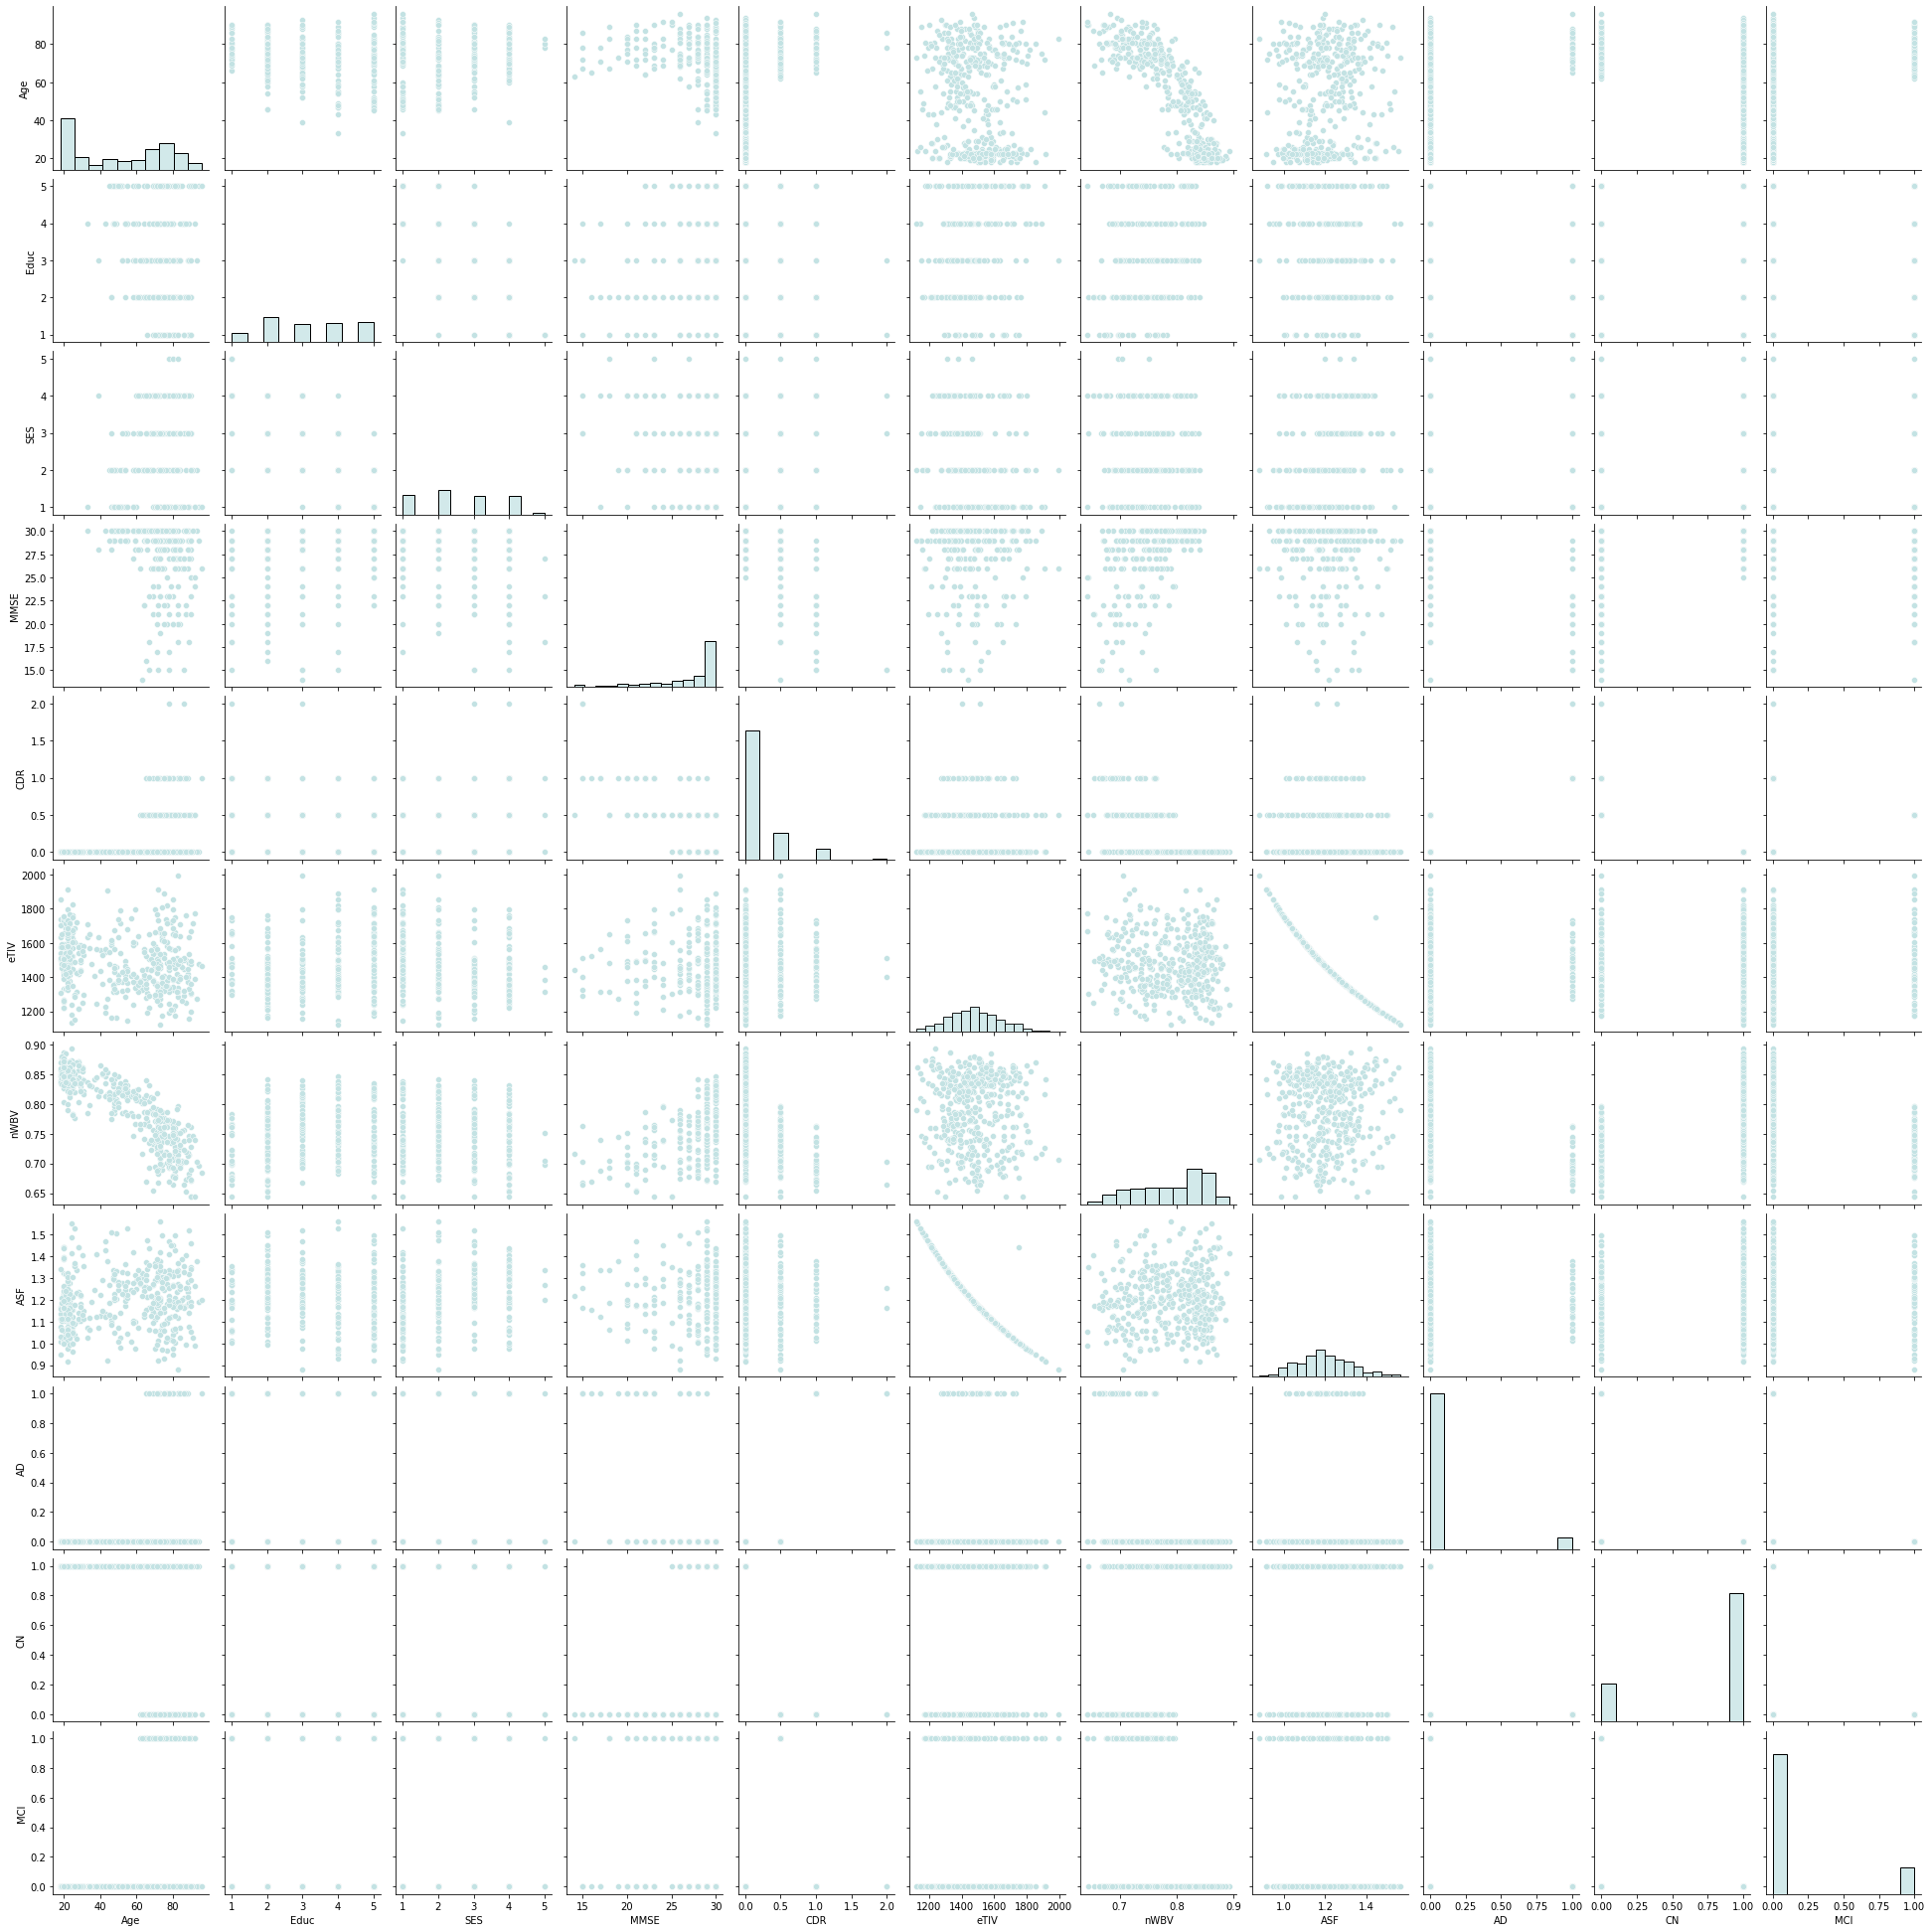

In [7]:
#Create a pairplot to visualize all the potential correlations in the dataset 
sns.pairplot(df);

This pairplot allows us to already see some patterns and distributions in the dataset. For example we can see that for the age category most of the people are younger than 60, so the distribution of the age is shifted to the left. For the age, we can also see that there is an inverse correlation of the Age with the brain volume (nWBV), meaning the brain volume decreases with age. For the MMSE distribution we see that most of the people achieved quite good results in the test, with the distribution being shifted to the right. We further see a trend of a correlation of the brain volume with the intracranial volume (eTIV). 

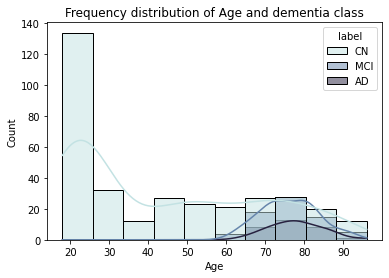

In [8]:
#Create a histogram that shows the distribution of Age and CDR in our dataset 
sns.histplot(data=df, x='Age', hue='label',kde=True, palette='ch:start=.2,rot=-.3').set(xlabel='Age', ylabel='Count')
plt.title('Frequency distribution of Age and dementia class');

This graph shows that our dataset is quite unbalanced with having many young people that have no dementia. In general, people younger than 60 only show very mild (CDR = 0.5) dementia, whereas the number of people having very mild dementia ore even more dramatic is increasing in the older population. 
In the next section we will remove the rows with the missing values and drop some columns that do not contain any information for us.

In [9]:
#drop the NaN values 
df.dropna(axis=0, inplace=True)

### Part 1.1 - Visualizations 

In the following part the data in the dataframe will be visualized to analyze if there are patterns or correlations in the dataset. The assumptions made at the beginning of the notebook will be analyzed and answered. 




In [10]:
#Plot showing the dementia cases per gender and age 
#create age bins first 
#since the risk of getting Alzheimer's increases in the high age, we only create two age bins with one until 65 and the other one above 
df_2 = pd.cut(df.Age, bins = 2, labels=['33-65', '65-96'])

#add age categories as a new column to the dataframe 
df=df.join(df_2, how='inner', rsuffix='_category')
df.head(2)

,ID,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,label,AD,CN,MCI,dataset,Age_category
0,OAS1_0001_MR1,F,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,CN,0,1,0,OASIS,65-96
1,OAS1_0002_MR1,F,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,CN,0,1,0,OASIS,33-65


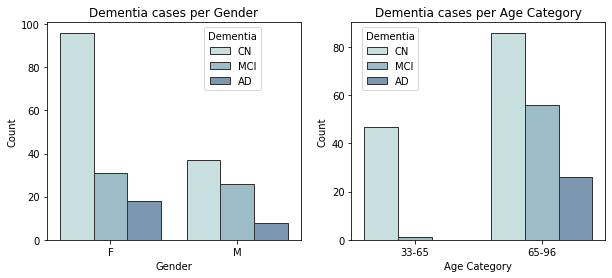

In [11]:
#Create the plot for dementia for age and gender 
fig, axes = plt.subplots(1,2, figsize=(10, 4))
axes[0].set_title('Dementia cases per Gender')
sns.countplot(data=df, x='M/F', hue='label', ax=axes[0], edgecolor=".2").set(xlabel='Gender', ylabel='Count')
axes[0].legend(title='Dementia',bbox_to_anchor=(0.6, 1), loc='upper left')

sns.countplot(data=df, x='Age_category', hue='label', ax=axes[1], edgecolor=".2").set(xlabel='Age Category', ylabel='Count')
axes[1].set_title('Dementia cases per Age Category')
axes[1].legend(title='Dementia',bbox_to_anchor=(0.02, 1), loc='upper left');

In [12]:
#Rename the M/F column to Gender and produce new dataframes for males and females 
df.rename({'M/F': 'Gender'}, axis=1, inplace=True)
df_male = df.query('Gender =="M"').groupby(['label']).label.count().sort_values(ascending=False)
df_female = df.query('Gender=="F"').groupby(['label']).label.count().sort_values(ascending=False)


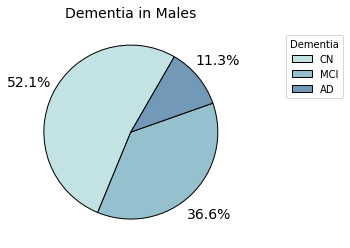

In [13]:
#Pie chart to see percentage of cases per Males 
textprops = {"fontsize":14} #set fontsize for text in pie chart 
wedgeprops={"edgecolor":"k",'linewidth': 1,'antialiased': True} #define the edges of the plot
df_male.plot(kind='pie', y='Gender', autopct='%.1f%%', labeldistance=None, pctdistance=1.3, textprops=textprops,wedgeprops=wedgeprops, startangle=60).yaxis.set_visible(False)
plt.legend(title='Dementia', bbox_to_anchor=(1.5,0.8), loc='right')
plt.title('Dementia in Males', fontsize=14, loc='center');

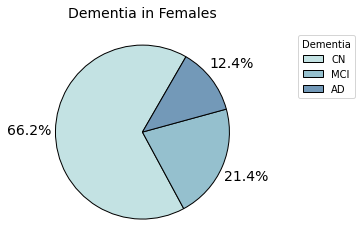

In [14]:
#Pie chart to see percentage of cases per Males 
textprops = {"fontsize":14} #set fontsize for text in pie chart 
wedgeprops={"edgecolor":"k",'linewidth': 1,'antialiased': True} #define the edges of the plot
df_female.plot(kind='pie', y='Gender', autopct='%.1f%%', labeldistance=None, pctdistance=1.3, textprops=textprops,wedgeprops=wedgeprops, startangle=60).yaxis.set_visible(False)
plt.legend(title='Dementia', bbox_to_anchor=(1.5,0.8), loc='right')
plt.title('Dementia in Females', fontsize=14, loc='center');

These two plots show that there are more dementia cases in males than in females (non-demented males=52%, non-demented females=66%). The percentage of males having mild dementia is 37% and 21% for females. Thus, we can conclude that the risk of getting dementia is higher for males than for females.

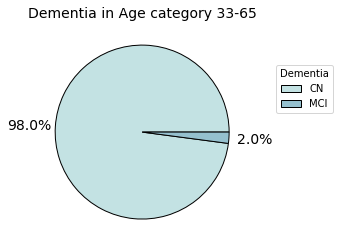

In [15]:
#Create pie charts to see the percentages of cases and not only count 
#create two new dataframes with young and old age category 
df_young = df.query('Age_category=="33-65"').groupby(['label']).label.count()
df_old = df.query('Age_category=="65-96"').groupby(['label']).label.count().sort_values(ascending=False)

#Have a pie chart for young age category 
textprops = {"fontsize":14} #set fontsize for text in pie chart 
wedgeprops={"edgecolor":"k",'linewidth': 1,'antialiased': True} #define the edges of the plot
df_young.plot(kind='pie', y='label', autopct=lambda p: '{:.1f}%'.format(round(p)) if p > 0.2 else '', labeldistance=None, pctdistance=1.3, textprops=textprops,wedgeprops=wedgeprops).yaxis.set_visible(False)
plt.legend(title='Dementia', bbox_to_anchor=(1.4,0.7), loc='right')
plt.title('Dementia in Age category 33-65', fontsize=14, loc='center');

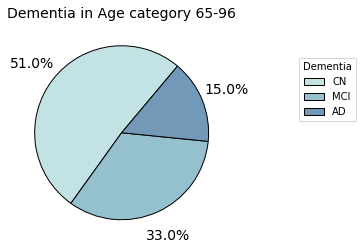

In [16]:
#Have a pie chart for old age category 
textprops = {"fontsize":14} #set fontsize for text in pie chart 
wedgeprops={"edgecolor":"k",'linewidth': 1,'antialiased': True} #define the edges of the plot 
df_old.plot(kind='pie', y='label', autopct=lambda p: '{:.1f}%'.format(round(p)) if p > 0.2 else '', labeldistance=None, pctdistance=1.3, textprops=textprops, startangle=50, wedgeprops=wedgeprops).yaxis.set_visible(False)
plt.legend(title='Dementia', bbox_to_anchor=(1.6,0.7), loc='right')
plt.title('Dementia in Age category 65-96', fontsize=14, loc='center');

For the first hypothesis we can conclude from these graphs that the risk of getting Alzheimer's is increasing with age since we have only 2% of cases with MCI in the age category 33-65 but 33% of cases with MCI and 15% with AD in the age class 65-96. However, in both age classes the amount of patients with no dementia is the highest (98% for young age category and 51% for the older ones).

In [17]:
#We create a new dataframe with the entries grouped by the Alzheimer stage 
df_pivot=pd.pivot_table(df, index=['Educ', 'label'], values='ID',aggfunc='count').reset_index()
df_pivot

,Educ,label,ID
0,1.0,AD,7
1,1.0,CN,8
2,1.0,MCI,8
3,2.0,AD,8
4,2.0,CN,29
5,2.0,MCI,15
6,3.0,AD,4
7,3.0,CN,29
8,3.0,MCI,11
9,4.0,AD,4


In [18]:
#count the non demented cases per education level 

import itertools

totals=[]
def count_totals(df, totals):
    '''Counts all the non-demented cases for the different education levels
    returns a list with the non-demented times three, to apply it to the remaining three dementia stages'''
    totals.append(df[(df['label']== "CN")&(df['Educ']==1)].ID.count())
    totals.append(df[(df['label']== "CN")&(df['Educ']==2)].ID.count())
    totals.append(df[(df['label']== "CN")&(df['Educ']==3)].ID.count())
    totals.append(df[(df['label']== "CN")&(df['Educ']==4)].ID.count())
    totals.append(df[(df['label']== "CN")&(df['Educ']==5)].ID.count())

count_totals(df, totals)
totals

[8, 29, 29, 30, 37]

In [19]:
#Adjust the totals list in such a way that it can be applied to the pivot table 
totals=[8,8,8,29,29,29,29,29,29,30,30,30,37,37,37]
len(totals)

#Calculate the ratio to the non-demented cases stored in the totals list 
df_pivot['ratio']=df_pivot['ID']/totals

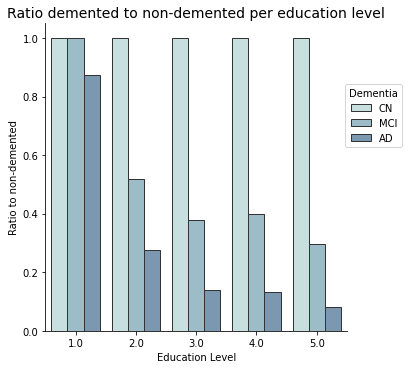

In [20]:
#Plot the ratio of demented to non-demented individuals with the education levels
hue_order=['CN','MCI', 'AD'] 
sns.catplot(data=df_pivot, kind='bar', x='Educ', y='ratio', hue='label', hue_order=hue_order, edgecolor=".2", legend=None).set(xlabel='Education Level', ylabel='Ratio to non-demented')
plt.legend(title='Dementia', bbox_to_anchor=(1.2,0.7), loc='right')
plt.title('Ratio demented to non-demented per education level', fontsize=14);

In this plot we can see that in the lowest education category the distribution of MCI cases is quite uniform, meaning we have a similar number of people with no dementia and MCI but also AD. For the other levels the amount of people with no dementia is always higher compared to the other stages. For the education level 2, the number of very mild and mild cases is slightly higher than in the other categories. This plot indicates that in the two lowest education levels the changes to get Alzheimer's are slightly higher which might correlate with the slightly higher mean age for these two categories.  

The MMSE is a cognitive test consisting of 11 questions. We assume that there is correlation of the mean points a person gets in the test (30 is the max number of points) and the dementia stage.

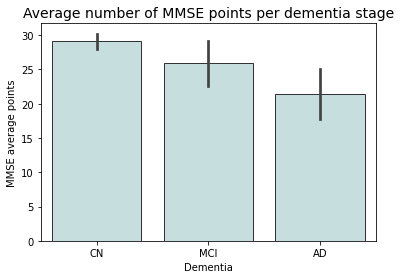

In [21]:
#Plot the average number of points per dementia stage 
sns.barplot(data=df, x='label', y='MMSE', color='#c3e2e3', ci='sd', edgecolor=".2").set(xlabel='Dementia', ylabel='MMSE average points')
plt.title('Average number of MMSE points per dementia stage', fontsize=14);

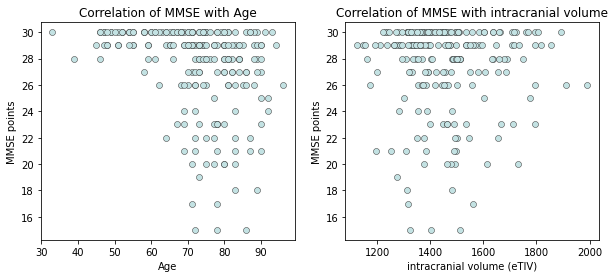

In [22]:
#Let us check if the number of MMSE points also correlates with the age and brain volume and intracranial volume 
fig, axes = plt.subplots(1,2, figsize=(10, 4))
axes[0].set_title('Correlation of MMSE with Age')
sns.scatterplot(data=df, x='Age', y='MMSE', ax=axes[0], edgecolor=".2").set(xlabel='Age', ylabel='MMSE points')

axes[1].set_title('Correlation of MMSE with intracranial volume')
sns.scatterplot(data=df, x='eTIV', y='MMSE', ax=axes[1], edgecolor=".2").set(xlabel='intracranial volume (eTIV)', ylabel='MMSE points');


We can conclude based on the plot that there is indeed a correlation of the MMSE rate and the stage of dementia. For the non demented individuals, the average number of points achieved is close to the maximum number possible, whereas for the moderate stage the patients achieved less than 15 points. 

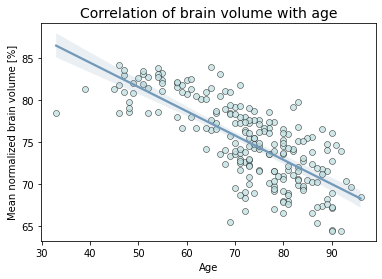

In [23]:
#Plot the brain volume with the age 
#Create a new column containing the brain volume in percentage 
df['Brain_volume'] = df['nWBV']*100
sns.regplot(data=df, x='Age', y='Brain_volume', x_ci='sd', scatter_kws={'linewidths':.5,'edgecolor':'k'}, line_kws={'color':'#7399b8'}).set(xlabel='Age', ylabel='Mean normalized brain volume [%]')
plt.title('Correlation of brain volume with age', fontsize=14);

From both plot we can conclude that there is a linear correlation between the brain volume and the age, which means that the brain volume decreases with age. 

### Part 2 - EDA of the images 

In the next section, we will investigate the MRI images from the OASIS_1 dataset and check if we find some general patterns that are correlated with Alzheimer's or healthy individuals.

In [24]:
#Load traverse image stacks 
tra, sag, cor= load_MRI_gifs(df["ID"], "all")
tra.shape

(216, 208, 176)

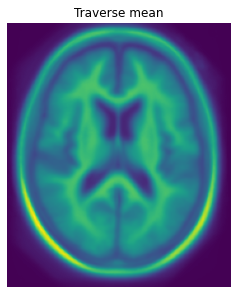

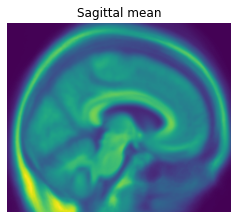

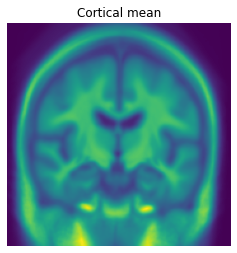

In [25]:
# Load the images - show the average of all images in the dataset 
# Load all three different axis 
traverse=img_mean(load_MRI_gifs(df["ID"], "traverse"), title= "Traverse mean")
sagittal=img_mean(load_MRI_gifs(df["ID"], "sagittal"), title= "Sagittal mean")
cortical=img_mean(load_MRI_gifs(df['ID'], "cortical"), title= "Cortical mean")

In [35]:
#Compare demented with non-demented MRI images 
compare_two_means(
    load_MRI_gifs(non_demented(df)["ID"], "traverse"),
    load_MRI_gifs(demented(df)["ID"], "traverse"), 
    "non-demented", "demented", vmax=120)

TypeError: compare_two_means() got an unexpected keyword argument 'cmap'

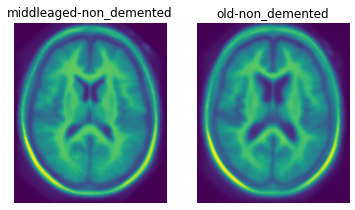

In [27]:
#Compare images of young and old non-demented individuals
compare_two_means(
    load_MRI_gifs(middleaged(non_demented(df))["ID"], "traverse"),
    load_MRI_gifs(old(non_demented(df))["ID"], "traverse"), 
    "middleaged-non_demented", "old-non_demented", vmax=120)

In [28]:
#Collect the image intensity data 
tra_info = get_stack_info(df,tra)
tra_info.head(2)

,ID,img_min,img_max,img_mean,img_median,height,width
0,OAS1_0001_MR1,0,189,40.1,34.0,208,176
1,OAS1_0002_MR1,0,206,49.7,50.0,208,176


In [29]:
#Get the image intensities for the three different axes 
tra_info = get_stack_info(df,tra)
sag_info = get_stack_info(df,sag)
cor_info = get_stack_info(df,cor)

(0.0, 255.0)

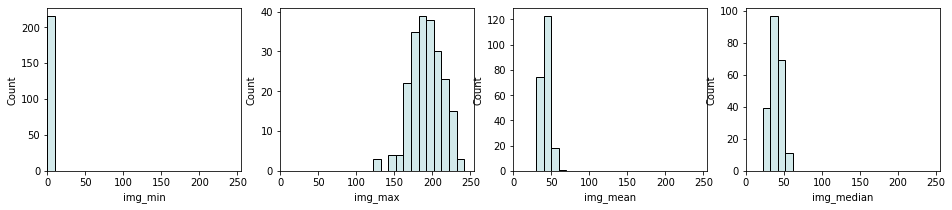

In [30]:
#Plot the intensity distribution for the traverse axis 
fig, axes = plt.subplots(1, 4, figsize=(16, 3), sharey=False)
sns.histplot(ax= axes[0], data= tra_info, x="img_min", binrange=(0,10)).set_xlim(0, 255)
sns.histplot(ax= axes[1], data= tra_info, x="img_max", binwidth=10).set_xlim(0, 255)
sns.histplot(ax= axes[2], data= tra_info, x="img_mean", binwidth=10).set_xlim(0, 255)
sns.histplot(ax= axes[3], data= tra_info, x="img_median", binwidth=10).set_xlim(0, 255)

(0.0, 255.0)

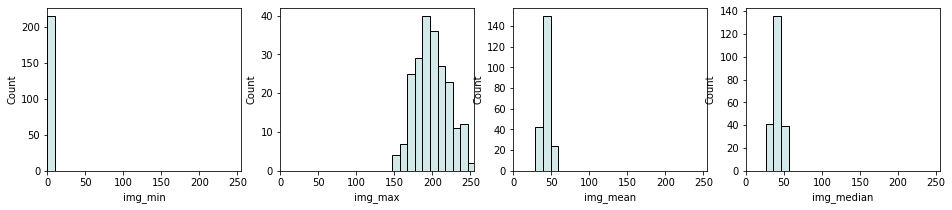

In [31]:
#Plot the intensity distribution for the sagittal axis 
fig, axes = plt.subplots(1, 4, figsize=(16, 3), sharey=False)
sns.histplot(ax= axes[0], data= sag_info, x="img_min", binrange=(0,10)).set_xlim(0, 255)
sns.histplot(ax= axes[1], data= sag_info, x="img_max", binwidth=10).set_xlim(0, 255)
sns.histplot(ax= axes[2], data= sag_info, x="img_mean", binwidth=10).set_xlim(0, 255)
sns.histplot(ax= axes[3], data= sag_info, x="img_median", binwidth=10).set_xlim(0, 255)

(0.0, 255.0)

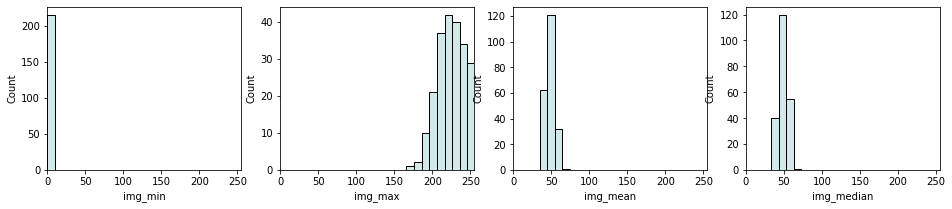

In [32]:
#Plot the intensity distribution for the cortical axis 
fig, axes = plt.subplots(1, 4, figsize=(16, 3), sharey=False)
sns.histplot(ax= axes[0], data= cor_info, x="img_min", binrange=(0,10)).set_xlim(0, 255)
sns.histplot(ax= axes[1], data= cor_info, x="img_max", binwidth=10).set_xlim(0, 255)
sns.histplot(ax= axes[2], data= cor_info, x="img_mean", binwidth=10).set_xlim(0, 255)
sns.histplot(ax= axes[3], data= cor_info, x="img_median", binwidth=10).set_xlim(0, 255)